In [44]:
%reset -f
# reset all stored variables

### Importing necessary libraries

In [45]:
#numpy, pandas, matplotlib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#PyTorch and its sub modules
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn


### Pre-process the data

In [46]:
os.getcwd()

'/Users/mic/Desktop/-Math_108C-Final-Project'

In [47]:
Current_Directory=os.getcwd()
Image_Directory=os.path.join(Current_Directory, "data/", "data")
Image_Directory

'/Users/mic/Desktop/-Math_108C-Final-Project/data/data'

the size of the image is (218, 178, 3)


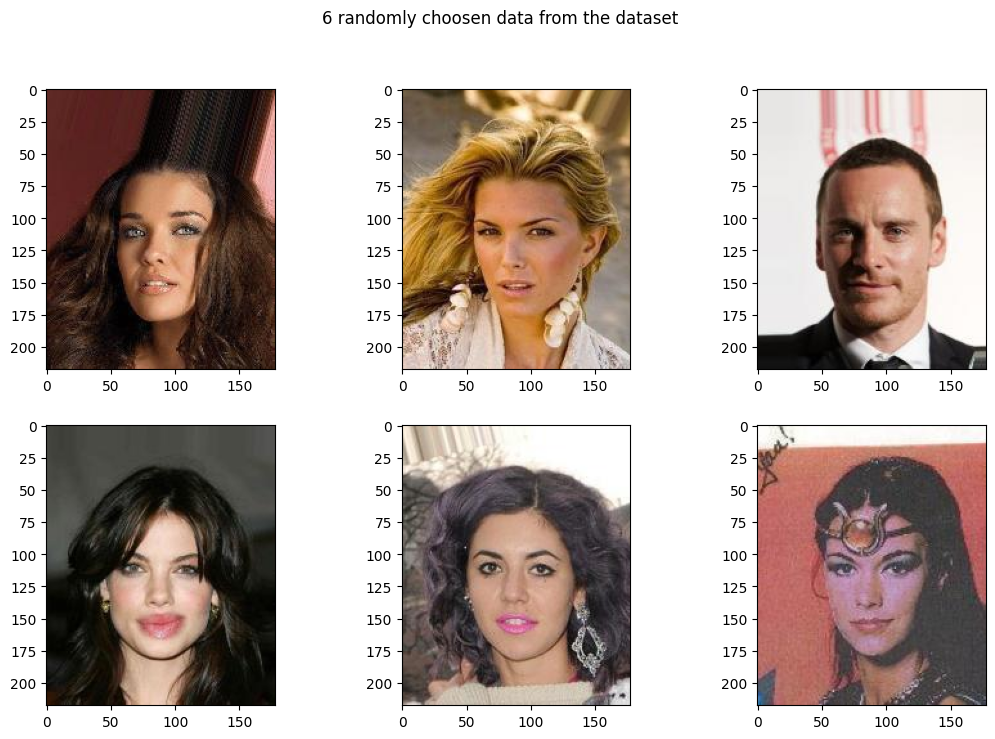

In [48]:
plt.figure(figsize=(13,8))
plt.suptitle("6 randomly choosen data from the dataset")
flag=0
for i in range(6):
        plt.subplot(2,3,i+1)
        choose_img_num=np.random.choice(os.listdir(Image_Directory))
        image_path=os.path.join(Image_Directory, choose_img_num)
        image=plt.imread(image_path)
        plt.imshow(image)
        
        if flag==0:
            print(f"the size of the image is {image.shape}")
            flag=1
plt.show()

In [49]:
train_transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()])
dataloader=DataLoader(dataset=torchvision.datasets.ImageFolder(os.path.join(Current_Directory, "data/"), transform=train_transform), batch_size=64)

In [50]:
all_features=[]
flag=1
for train_features, train_labels in dataloader:
    all_features.append(train_features)
    
    if flag==1:
        print(f"Feature batch shape: {train_features.shape}")
        flag=0

all_features=torch.cat(all_features, dim=0)
all_features.shape

Feature batch shape: torch.Size([64, 1, 218, 178])


torch.Size([5000, 1, 218, 178])

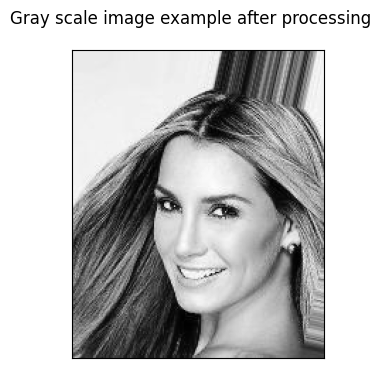

In [51]:
plt.figure(figsize=((6,4)))
plt.suptitle("Gray scale image example after processing")
plt.xticks(())
plt.yticks(())
plt.imshow(all_features[0].squeeze(), cmap="gray")

### Autoencoder

Now we have all_features which contains the data we are going to use in training. It is in $$R^{5000 \times 1 \times 218 \times 178}$$
where the data contains 5000 images, and each image has the dimension layers $\times$ height $\times$ width. All 5000 images are changed to gray-scaled for better learning and quicker training process. 

Below we create the autoencoder model. Here I use convolution layers as encoder and deconvolution layers as decoder. 

In [52]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=144, out_features=latent_dim)
        
    def forward(self, x):
        x = self.conv1(x)
        x, indice1 = self.pool1(x)
        
        x = self.conv2(x)
        x, indice2 = self.pool2(x)
        
        x = self.conv3(x)
        x, indice3 = self.pool3(x)
        
        x = self.flatten(x)
        latent_representation = self.fc(x)
        
        indices=(indice1, indice2, indice3)
        return latent_representation, indices

In [60]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.decoder=nn.Sequential(
            nn.Linear(latent_dim, 144),
            nn.ReLU(),
            nn.Linear(144, 144*3),
            nn.ReLU(),
            nn.Linear(144*3,144*36),
            nn.ReLU(),
            nn.Linear(144*36, 218*178),
            nn.Sigmoid()
        )
        '''
        self.unpool3=nn.MaxUnpool2d(kernel_size=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=3, stride=2)
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=3, stride=2)
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=3, stride=2)
        '''

    def forward(self, x, indices):
        result=self.decoder(x)
        return result
        
        """
        indice1, indice2, indice3=indices
        x=self.fc(x)
        x=x.view(-1, 24, 3, 2)
        x=self.unpool3(x, indice3)
        x=self.deconv3(x)
        x=self.unpool2(x, indice2)
        x=self.deconv2(x)
        x=self.unpool1(x, indice1)
        result=self.deconv1(x)
        """
        return result
        
        

In [61]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self, x):
        latent_representation, indices=self.encoder(x)
        result=self.decoder(latent_representation, indices)
        return result, latent_representation
    

In [62]:
model=Autoencoder(Encoder(), Decoder())
model

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=144, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=144, bias=True)
      (1): ReLU()
      (2): Linear(in_features=144, out_features=432, bias=True)
      (3): ReLU()
      (4): Linear(in_features=432, out_features=5184, bias=True)
      (5): ReLU()
      (6): Linear(in_features=5184, out_features=38804, bias=True)
      (7): Sigmoid()
    )
  )
)

### Training the model

We first define our loss function and optimization method

In [63]:
loss_fn=nn.MSELoss() #L2 norm
optimizer=torch.optim.Adam(model.parameters(), lr=0.001) #adam algorithm

In [64]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    
    total_loss=0
    
    for feature, _ in dataloader:
        result, latent_representation=model(feature)
        loss=loss_fn(result, feature.reshape(-1,218*178))
        total_loss+=loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Loss on train data set this epoch {total_loss}")
    return total_loss
    

In [79]:
num_epoches=5
loss_record_train=[]
for epoch in range(num_epoches):
    print(f"epoch {epoch+1} ----------------------")
    total_loss_train=train_loop(dataloader, model, loss_fn, optimizer)
    loss_record_train.append(total_loss_train)

epoch 1 ----------------------
Loss on train data set this epoch 1.9075488671660423
epoch 2 ----------------------
Loss on train data set this epoch 1.8872979003936052
epoch 3 ----------------------
Loss on train data set this epoch 1.868276882916689
epoch 4 ----------------------
Loss on train data set this epoch 1.8495734231546521
epoch 5 ----------------------
Loss on train data set this epoch 1.8366846665740013


### Plotting the training loss and Checking the decoded result

In [80]:
def plot_loss(loss_record_train):
    plt.figure(figsize=(5,5))
    plt.suptitle("Traning loss after each epoch")
    plt.plot(loss_record_train)
    
    plt.show()

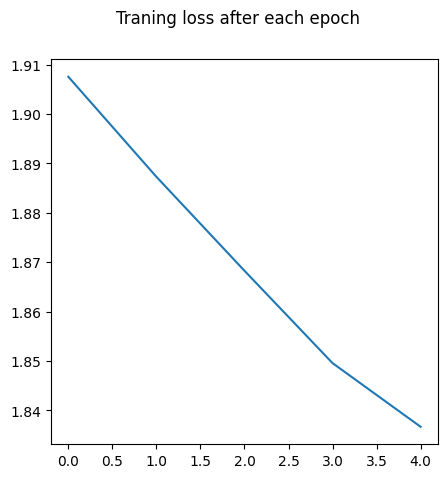

In [81]:
plot_loss(loss_record_train)

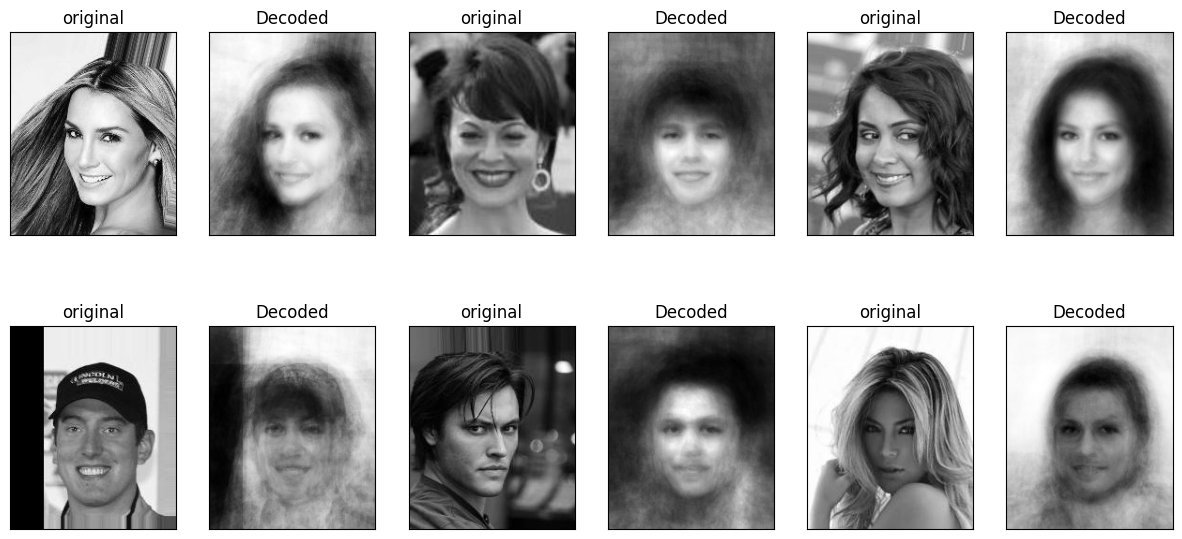

In [82]:
plt.figure(figsize=(15,7))
count=0
pos=0

for feature, label in dataloader:
    example=feature[count, :]
    with torch.no_grad():
        result, latent_representation=model(example.reshape(1,1,218,178))
        
    pos+=1
    ax1=plt.subplot(2,6,pos)
    ax1.set_title("original")
    plt.xticks(())
    plt.yticks(())
    plt.imshow(example.reshape(218,178,1), cmap="gray")
    
    
    pos+=1
    ax2=plt.subplot(2,6,pos)
    ax2.set_title("Decoded")
    plt.xticks(())
    plt.yticks(())
    plt.imshow(result.reshape(218,178,1), cmap="gray")
    
    count+=1
    if count>=6:
        break


### Retrieving the Latent space

In [69]:
for feature, label in dataloader:
    with torch.no_grad():
        result, latent_representation=model(feature)


In [70]:
print(f"the shape of result is {result.shape}, the shape of latent space is {latent_representation.shape}")

the shape of result is torch.Size([8, 38804]), the shape of latent space is torch.Size([8, 10])
